In [1]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
np.random.seed(77)

In [32]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

# def gen_from_iad(f, M, n):
#     # f(): returns a positive integer IAD sample
#     h = [(f(), i) for i in range(M)]
#     heapq.heapify(h)
#     trace = []
#     for _ in range(n):
#         t, addr = heapq.heappop(h)
#         trace.append(addr)
#         heapq.heappush(h, (t + f(), addr))
#     return np.array(trace, dtype=np.int32)

In [19]:
lmb, irm2 = gen_from_zipf(120, 10000000, 0.8)
ph2 = gen_ph(120, 0.8, 10000000)

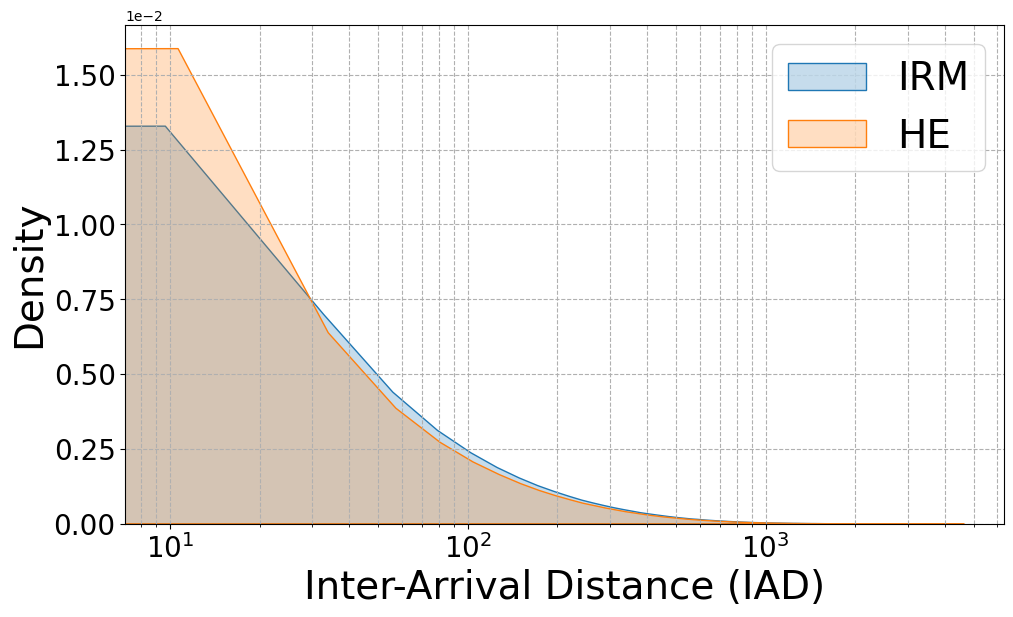

In [20]:
# iads should match
iads1 = tg.iad(irm2)
iads1 = iads1[irm2 > 0]
iads2 = tg.iad(ph2)
iads2 = iads2[ph2 > 0]
plt.figure(figsize=(10,6))
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(iads2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.tight_layout()
plt.xscale('log')
plt.xlabel('Inter-Arrival Distance (IAD)', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

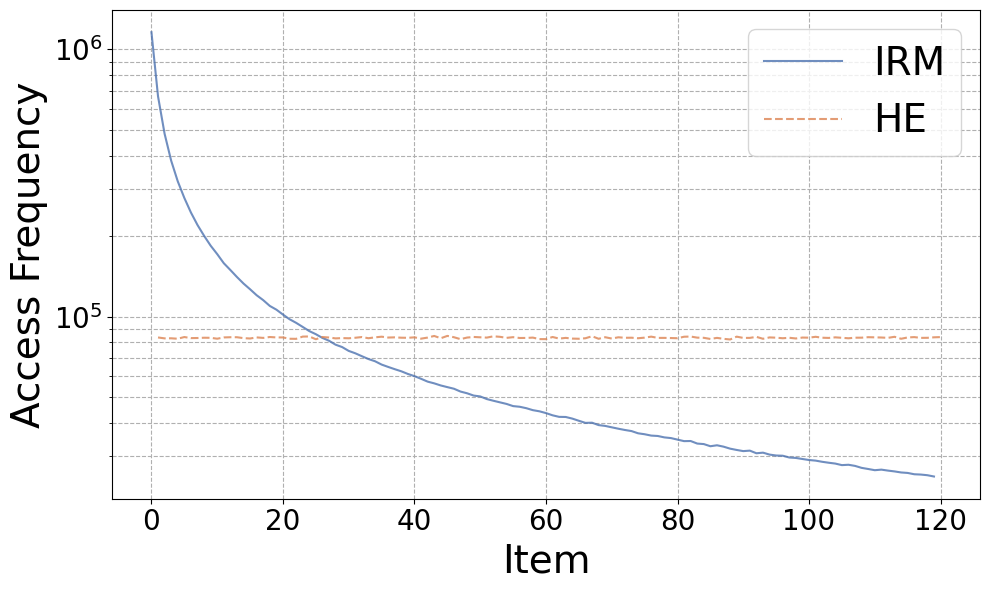

In [21]:
# frequency should not match
u1, c1 = np.unique(irm2, return_counts=True)
u2, c2 = np.unique(ph2, return_counts=True)

plt.figure(figsize=(10,6))
plt.semilogy(u1, c1, label='IRM', color=palette[0], alpha=0.8)
plt.semilogy(u2, c2, label='HE', color=palette[1], alpha=0.8, linestyle='--')

ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.xlabel('Item', fontsize=28)
plt.ylabel('Access Frequency', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


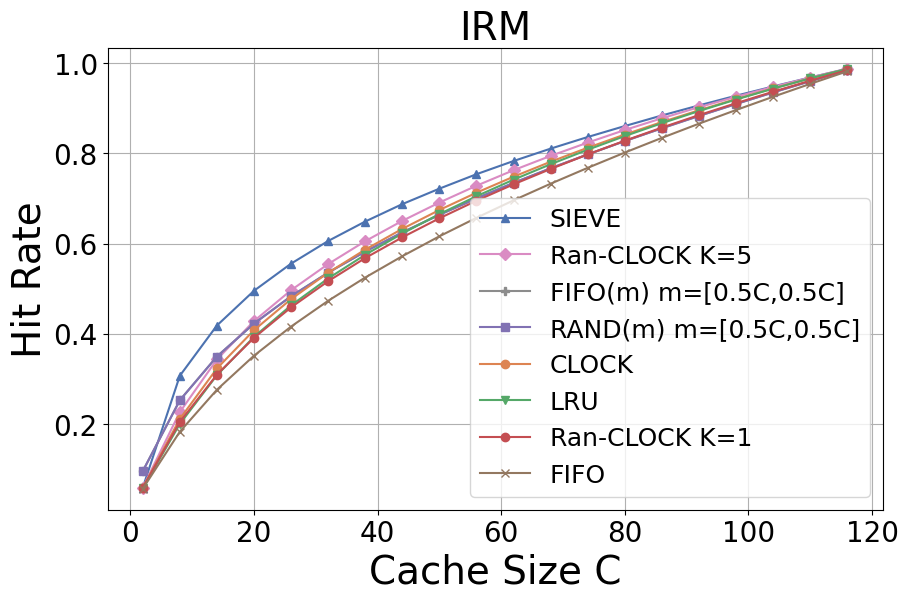

IRM Average Hit Rates:
SIEVE: 0.7082250099999999
Ran-CLOCK K=5: 0.681197805
CLOCK: 0.6692786599999999
FIFO(m) m=[0.5C,0.5C]: 0.6681728
RAND(m) m=[0.5C,0.5C]: 0.6681547299999999
LRU: 0.6626571950000001
Ran-CLOCK K=1: 0.656421335
FIFO: 0.629072615


In [ ]:
c1, hr_ran_clock1 = sim_ran_clock(irm2, cnt=1)
c5, hr_ran_clock5 = sim_ran_clock(irm2, cnt=5)
cl, hr_fifo_m = sim_fifo_m(irm2)
cr, hr_rand_m = sim_rand_m(irm2)
cc, hr_clock = sim_clock(irm2)
cs, hr_sieve = sim_sieve(irm2)
cl, hr_lru = sim_lru(irm2)
cf, hr_fifo = sim_fifo(irm2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(True)
# ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(True)
# ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(c5, hr_ran_clock5, color=palette[6], marker='D', label='Ran-CLOCK K=5')
plt.plot(cl, hr_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cr, hr_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(c1, hr_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.show()

avgs = [('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK K=1', np.mean(np.array(hr_ran_clock1))),
        ('Ran-CLOCK K=5', np.mean(np.array(hr_ran_clock5))),
        ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_rand_m))),
        ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_fifo_m))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

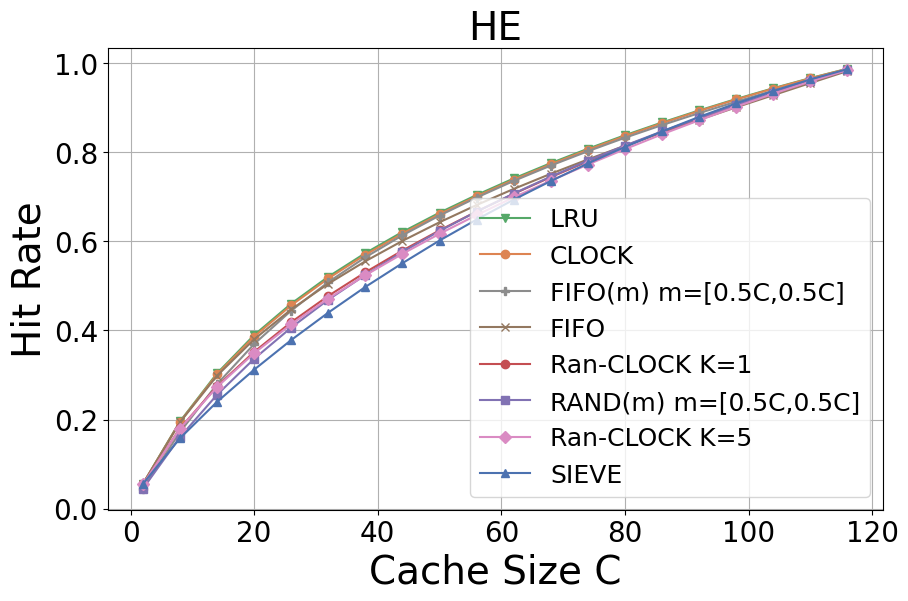

HE Average Hit Rates:
LRU: 0.66123214
CLOCK: 0.659076495
FIFO(m) m=[0.5C,0.5C]: 0.65178911
FIFO: 0.6454209399999999
Ran-CLOCK K=1: 0.63503383
RAND(m) m=[0.5C,0.5C]: 0.630751135
Ran-CLOCK K=5: 0.6306704000000001
SIEVE: 0.6209193049999999


In [42]:
cph1, hr_ph_ran_clock1 = sim_ran_clock(ph2, cnt=1)
cph5, hr_ph_ran_clock5 = sim_ran_clock(ph2, cnt=5)
cl_ph, hr_ph_fifo_m = sim_fifo_m(ph2)
cr_ph, hr_ph_rand_m = sim_rand_m(ph2)
cc_ph, hr_ph_clock = sim_clock(ph2)
cs_ph, hr_ph_sieve = sim_sieve(ph2)
cl_ph, hr_ph_lru = sim_lru(ph2)
cf_ph, hr_ph_fifo = sim_fifo(ph2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cl_ph, hr_ph_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cc_ph, hr_ph_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl_ph, hr_ph_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cf_ph, hr_ph_fifo, color=palette[5], marker='x', label='FIFO')
plt.plot(cph1, hr_ph_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cr_ph, hr_ph_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cph5, hr_ph_ran_clock5, color=palette[6], marker='D', label='Ran-CLOCK K=5')
plt.plot(cs_ph, hr_ph_sieve, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_ph_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1))),
         ('Ran-CLOCK K=5', np.mean(np.array(hr_ph_ran_clock5))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

In [43]:
assert cph1.all() == cph5.all() == cl_ph.all() == cr_ph.all() == cc_ph.all() == cs_ph.all() == cf_ph.all() == c1.all() == c5.all() == cl.all() == cr.all() == cc.all() == cs.all() == cf.all()

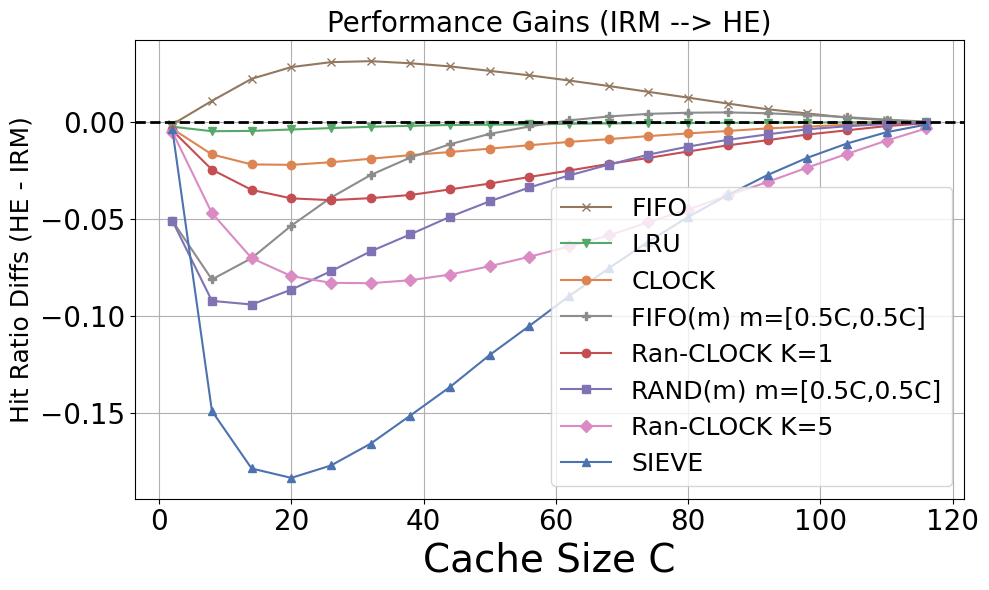

In [48]:
policies = ["FIFO", "LRU", "CLOCK", "FIFO(m) m=[0.5C,0.5C]", "Ran-CLOCK K=1", "RAND(m) m=[0.5C,0.5C]", "Ran-CLOCK K=5", "SIEVE"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_fifo_m, hr_ran_clock1, hr_rand_m, hr_ran_clock5, hr_sieve]
he_hr  = [hr_ph_fifo, hr_ph_lru, hr_ph_clock, hr_ph_fifo_m, hr_ph_ran_clock1, hr_ph_rand_m, hr_ph_ran_clock5, hr_ph_sieve]
colors = [palette[5], palette[2], palette[1], palette[7], palette[3], palette[4], palette[6], palette[0]]
markers = ['x', 'v', 'o', 'P', 'o', 's', 'D', '^']

c = cph1
rows = []
for name, irm, he in zip(policies, irm_hr, he_hr):
    irm = np.array(irm)
    he  = np.array(he)
    delta = he - irm
    for C, d in zip(c, delta):
        rows.append({"C": C, "policy": name, "delta_hr": d})

df_delta = pd.DataFrame(rows)
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
for name, color, marker in zip(policies, colors, markers):
    sub = df_delta[df_delta["policy"] == name]
    plt.plot(sub["C"], sub["delta_hr"], marker=marker, label=name, color=color)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel("Cache Size C", fontsize=28)
plt.ylabel("Hit Ratio Diffs (HE - IRM)", fontsize=18)
plt.title("Performance Gains (IRM --> HE)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
avgs3 = [('SIEVE', np.mean(np.array(hr_ph_sieve) - np.array(hr_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock) - np.array(hr_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru) - np.array(hr_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1) - np.array(hr_ran_clock1))),
         ('Ran-CLOCK K=5', np.mean(np.array(hr_ph_ran_clock5) - np.array(hr_ran_clock5))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m) - np.array(hr_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m) - np.array(hr_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo) - np.array(hr_fifo)))]
avgs3.sort(key=lambda x: x[1], reverse=True)
print("Performance gains:")
for name, avg in avgs3:
    print(f"{name}: {avg}")

Performance gains:
FIFO: 0.016348325000000018
LRU: -0.0014250550000000084
CLOCK: -0.01020216499999998
FIFO(m) m=[0.5C,0.5C]: -0.01638369
Ran-CLOCK K=1: -0.021387504999999973
RAND(m) m=[0.5C,0.5C]: -0.037403595
Ran-CLOCK K=5: -0.05052740500000001
SIEVE: -0.08730570499999998


In [50]:
# verify simulation for fifo(m) matches paper
trace = gen_from_zipf(300, 20000000, 0.8)[1]
hr1 = tg.sim_fifo_m([2, 98], trace)
hr2 = tg.sim_fifo_m([30, 70], trace)
hr3 = tg.sim_fifo_m([98, 2], trace)
print(1-hr1, 1-hr2, 1-hr3)
trace2 = gen_from_zipf(3000, 20000000, 0.8)[1]
hr11 = tg.sim_fifo_m([20, 980], trace2)
print(1-hr11)
hr22 = tg.sim_fifo_m([300, 700], trace2)
print(1-hr22)
hr33 = tg.sim_fifo_m([980, 20], trace2)
print(1-hr33)
trace3 = gen_from_zipf(300, 20000000, 1.1)[1]
hr111 = tg.sim_fifo_m([2, 98], trace3)
print(1-hr111)
hr222 = tg.sim_fifo_m([30, 70], trace3)
print(1-hr222)
hr333 = tg.sim_fifo_m([98, 2], trace3)
print(1-hr333)
hr1111 = tg.sim_fifo_m([2, 2, 96], trace)
print(1-hr1111)
hr2222 = tg.sim_fifo_m([10, 30, 60], trace)
print(1-hr2222)
hr3333 = tg.sim_fifo_m([20, 2, 78], trace)
print(1-hr3333)
hr4444 = tg.sim_fifo_m([90, 8, 2], trace)
print(1-hr4444)
hr5555 = tg.sim_fifo_m([1, 4, 10, 85], trace)
print(1-hr5555)
hr6666 = tg.sim_fifo_m([5, 15, 25, 55], trace)
print(1-hr6666)
hr7777 = tg.sim_fifo_m([25, 25, 25, 25], trace)
print(1-hr7777)
hr8888 = tg.sim_fifo_m([60, 2, 2, 36], trace)
print(1-hr8888)

0.34670274999999995 0.36061129999999997 0.42372680000000007
0.30476520000000007
0.31605020000000006
0.37229825000000005
0.17202220000000001
0.18318115000000001
0.23616910000000002
0.31694225
0.3294091
0.32739615
0.40918640000000006
0.30421495
0.3134912999999999
0.3343615
0.35123664999999993
